# Parameterizing MD correlation functions

In the previous section, we learned how to derive order parameters and correlation functions from an MD trajectory. Now, the question is, how do we acquire NMR rate constants from the correlation functions. To begin, we give the formula for a few rate constants.

$$
\begin{eqnarray}
R_1^I&=& \left(\frac{\delta^{IS}}{4}\right)^2(J(\omega_I-\omega_S)+3J(\omega_I)+6J(\omega_I+\omega_S))+\frac13(\omega_I\Delta\sigma_I)^2J(\omega_I)\\
R_2^I&=& \frac12R_1^I+\left(\frac{\delta^{IS}}{4}\right)^2(J(\omega_S)+2J(0)+\frac29(\omega_I\Delta\sigma_I)^2J(0)\\
\Gamma_{IS}&=& \left(\frac{\delta^{IS}}{4}\right)^2(-J(\omega_I-\omega_S)+6J(\omega_I+\omega_S))
\end{eqnarray}
$$

These yield the orientationally averaged rate constants, which is relevant in solids where the relaxation is multiexponential. The critical terms are the sizes of the interactions ($\delta^{IS}$, $\omega_I\Delta\sigma_I$), and the frequencies at which the spectral densities are sampled (0, $\omega_S$, $\omega_I$, $\omega_I\pm\omega_S$).

The spectral density itself is given by the real part of the Fourier transform, that is:

$$
J(\omega)=2\int\limits_0^\infty{C(t)\cos(\omega t)dt}
$$

We usually assume that $C(t)$ is symmetric in time, so that we integrate from 0 instead of $-\infty$, and multiply by 2. A factor of 1/5 needs to appear in the correlation function to account for the isotropic average over starting orientations. This factor is sometime incorporated into the correlation function for overall tumbling, i.e. for isotropic tumbling the correlation function is $C(t)=\frac15\exp(-t/\tau_M)C_{int.}(t)$. What we have calculated in the previous section is $C_{int.}(t)$

We could, in principle, Fourier transform the correlation functions from the previous section directly (after subtracting the order parameter away). Instead, what we usually do is assume the correlation function is a sum of exponentially decaying functions, and fit the corresponding parameters. 

$$
C_{int}(t)=S^2+(1-S^2)\sum\limits_i{A_i\exp(-t/\tau_i)}
$$

For just two correlation times, this is often written as

$$
C_{int}(t)=S^2_fS^2_s+(1-S_f^2)\exp(-t/\tau_f)+S_f^2(1-S_s^2)\exp(-t/\tau_s)
$$

Then, $S^2=S_f^2S_s^2$, $A_f=(1-S_f^2)$, and $A_s=S_f^2(1-S_s^2)$. We'll use the former equation for simplicity.

In this case, the spectral density may be written as follows, noting that the Fourier transform of an exponential is a Lorentzian function

$$
J(\omega)=2\sum\limits_i{A_i\frac{\tau_i}{1+(\omega\tau_i)^2}}
$$

## Setup
We need to repeat the initial setup performed in the first notebook

In [1]:
# Make sure pyDR is installed and on the path
import sys
import os
if 'google.colab' in sys.modules: #Colab
    !git clone https://github.com/alsinmr/pyDR
else:
    os.chdir('../../..')

In [7]:
# imports
import pyDR
pyDR.Defaults['zrange']=[-14,-3,200]
from pyDR.Fitting.fit import model_free
from pyDR.MDtools import vft
from pyDR.misc.tools import linear_ex
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from time import time
from copy import copy

In [8]:
# Download the trajectory files
xtc='https://drive.google.com/file/d/1wq5T-YDmPo2zAIWu9we2zyL2i-v52fnD/view?usp=sharing'
pdb='https://drive.google.com/file/d/1aBMUO2C1AZfx05dANl4QITHuqmHbDDsN/view?usp=sharing'

if not(os.path.exists('ubi.pdb')):
    pyDR.IO.download(pdb,'ubi.pdb')
if not(os.path.exists('ubi.xtc')):
    pyDR.IO.download(xtc,'ubi.xtc')

In [9]:
def align(uni,fileout='ubi_aligned.xtc',ref_sel='name CA'):
    """
    This function takes a trajectory and aligns it based on
    a reference selection of atoms. The new trajectory is
    returned in fileout (default is ubi_aligned.xtc)
    """
    
    from scipy.linalg import svd
    
    uni.trajectory[0] #Go to the first frame of the trajectory
    atoms=uni.atoms   #All atoms in the trajectory
    ref_sel=uni.select_atoms(ref_sel)  #Atom group for the reference
    
    ref0=ref_sel.positions #initial positions of reference atoms
    ref0-=ref0.mean(0) #Centers the initial position
    
    with mda.Writer(fileout,atoms.n_atoms) as W:
        for ts in uni.trajectory:
            ref=ref_sel.positions
            pos=atoms.positions

            pos-=ref.mean(0)   #This centers the reference
            ref-=ref.mean(0)   
            
            H=ref0.T@ref       #3x3 matrix
            U,S,Vt=svd(H)      #Singular value decomposition
            V=Vt.T             #Transposes
            Ut=U.T

            R=V@Ut             #Rotation matrix for alignment
            
            pos_corr=(R.T@pos.T).T
            atoms.positions=pos_corr
            
            W.write(atoms)
    return

In [10]:
uni0=mda.Universe('ubi.pdb','ubi.xtc')
if not(os.path.exists('ubi_aligned.xtc')):
    align(uni0,fileout='ubi_aligned.xtc')   #Runs the code to align Ubiquitin in the universe
uni=mda.Universe('ubi.pdb','ubi_aligned.xtc')  #Loads the aligned trajectory

## pyDIFRATE initial data load
We'll work with pyDIFRATE in this notebook. We'll start with a project (`proj=pyDR.Project`) and load NMR data into it which is downloaded online, and also load correlation functions into it from an MD trajectory.

pyDIFRATE does a lot of things for you automatically. The advantage here is that we'll get through the problems more quickly, but the downside is that you'll have to accept that some of the parameters are indeed calculated correctly ;-).

In [96]:
def load_proj():
    proj=pyDR.Project()
    proj.append_data('https://raw.githubusercontent.com/alsinmr/pyDR_tutorial/main/data/ubi_soln.txt')
    data=proj[0].__copy__()
    R00=data.R[0,0]
    data.R[0,0]=0
    data.sens=pyDR.Sens.NMR(info=data.sens.info)
    proj.append_data(data)
    data.R[0,0]=R00
    proj[-1].source.filename='ubi.text'


    sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi_aligned.xtc',project=proj)
    sel.select_bond('15N')
    pyDR.md2data(sel)

    sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi.xtc',project=proj)
    sel.select_bond('15N')
    pyDR.md2data(sel)


    return proj

In [97]:
proj=load_proj()

# Time axis for correlation functions
data=proj['raw']['MD'][0]
t=data.sens.info['t']  #ns

# Residues in the simulation
resids=data.label
print(proj)

Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
pyDIFRATE project with 4 data sets

titles:
r:NMR:ubi_soln
r:NMR:ubi
r:MD:ubi_aligned
r:MD:ubi



## Plot the spectral density
We can obtain the spectral density via Fourier transform of the correlation function. 

We first note that the correlation functions and order parameters are stored in the project. We plot one for example.

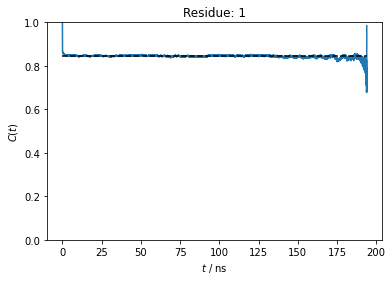

In [14]:
resi=1
i=np.argmax(resids==resi) # Finds where this is true  
data=proj['MD']['raw']['.+aligned']  #Finds the unprocessed MD data

ax=plt.subplots()[1]
ax.plot(t,data.R[i])
ax.plot(t[[0,-1]],np.ones(2)*data.S2[i],color='black',linestyle='--')
ax.set_xlabel(r'$t$ / ns')
ax.set_ylabel(r'$C(t)$')
ax.set_title(f'Residue: {resi}')
_=ax.set_ylim([0,1])

Plot the spectral density for a few residues (code below)

In [15]:
resi=5
i=np.argmax(resids==resi) # Finds where this is true  
Ct=data.R[i]-data.S2[i]
Ct[0]/=2  #Single-sided FT, need to cut first point in half
dt=(t[1]-t[0])*1e-9
J=2*np.fft.fftshift(np.fft.fft(Ct[:len(Ct)//2],n=len(Ct))).real*dt

f=1/(2*dt)*np.linspace(-1,1,len(t))/1e6
f-=(f[1]-f[0])/2

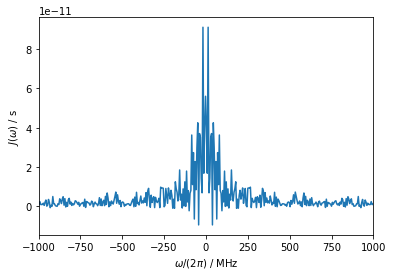

In [16]:
ax=plt.subplots()[1]
ax.plot(f,J)
ax.set_xlabel(r'$\omega/(2\pi)$ / MHz')
ax.set_ylabel(r'$J(\omega)$ / s')
_=ax.set_xlim([-1000,1000])

### Exercise 1.1
Why do we recommend fitting the correlation function rather than taking the correlation function directly?

```{toggle}
The Fourier transform is too noisy to be used to get reliable rate constants. With smoothing or fitting, it can, however, provide reliable results.

We instead fit the correlation function as a multi-exponential decay and use the parameters in the expression above for the spectral density, $J(\omega)$.
```

## Multi-exponential fitting (model-free-like analysis)
We define a class below to extract model free parameters from MD-derived correlation functions.

In [ ]:
proj=load_proj()

In [134]:
class MF():
    def __init__(self,n:int=5,aligned:bool=True,Type='MD',proj=proj):
        self._Type=Type
        self.proj=proj
        self._n=None
        self.aligned=aligned
        self._z=None
        self._A=None
        self.fit=None
        self.chi2=None
        self.n=n
    
    @property
    def Type(self):
        return self._Type
    
    @Type.setter
    def Type(self):
        assert 0,'Type (MD/NMR) cannot be changed after initialization'
        
    def _title(self,pre):
        if pre=='n':
            pre='n12' if self.Type=='MD' else 'n6'
            
        if self.Type=='MD':
            return f'{pre}:MD:ubi'+('_aligned' if self._aligned else '$')
        return f'{pre}:NMR:ubi'+('_soln' if self._aligned else '$')
    
    def _mdtitle(self,pre):
        return f'{pre}:MD:ubi'+('_aligned' if self._aligned else '$')
                
    @property
    def n(self):
        return self._n
    
    @n.setter
    def n(self,n):
        if hasattr(self,'_n') and n==self._n:
            return
        self._n=n
        if len(proj[self._title(f'p{n}')])==0:
            self.proj[self._title('n')].detect.r_auto(n=n)
            self.proj[self._title('n')].fit()
        data=proj[self._title(f'p{n}')][0]
        fixz=[-14,*[None for _ in range(self.nz-1)]] if n%2==1 else None
        z,A,chi2,fit=model_free(data,self.nz,fixz=fixz,include=[True for _ in range(n)])
        self.z=z
        self.A=A
        self.fit=fit
        self.chi2=chi2
        
    @property
    def nz(self):
        return np.ceil(self.n/2).astype(int)
        
    @property
    def aligned(self):
        return self._aligned
    
    @aligned.setter
    def aligned(self,aligned):
        if hasattr(self,'_aligned') and self._aligned==aligned:
            return
        
        self._aligned=aligned
        
        nd=12 if self.Type=='MD' else 6
        if len(proj[self._title('n')])==0:
            proj[self._title('r')].detect.r_no_opt(nd)
#             if self.Type!='MD':proj[self._title('r')][0].detect.R2ex()
            proj[self._title('r')].fit()
#             proj[self._title('n')].del_exp(index=-1)
        
        if self._n is not None:
            n=self.n    #Force a re-calculation
            self._n=0  
            self.n=n
        
    @property
    def tc(self):
        return 10**self.z
    
    @property
    def S2_fit(self):
        return 1-self.A.sum(0)
    
    @property
    def S2(self):
        return self.proj[self._title('r')].S2
    
    @property
    def resids(self):
        return self.proj[self._title('r')].label
    
    @property
    def t(self):
        return self.proj['MD']['raw']['ubi_aligned'].info['t'].astype(float)
    
    def plot_pars(self,ax:list=None):
        if ax is None:
            fig,ax=plt.subplots(self.nz,2,sharex=True)
        for k,ax0 in enumerate(ax):
            i=self.A[k]>1e-3
            ax0[0].scatter(self.resids[i],self.A[k][i],s=5,color='red')
            ax0[0].set_ylabel('A')
            ax0[1].scatter(self.resids[i],self.z[k][i],s=5,color='red')
            ax0[1].set_ylabel(r'$\log_{10}(\tau_c$ / s$)$')
            if ax0[0].is_last_row():
                for a in ax0:a.set_xlabel('Residue')
        
        fig.set_size_inches([8,9])
        fig.tight_layout()
        return ax
    
    @property
    def Ct_fit(self):
        ct=np.ones([len(self.t),len(self.resids)])*self.S2_fit
        for tc0,A0 in zip(self.tc,self.A):
            ct+=np.exp(-np.kron(np.atleast_2d(self.t*1e-9).T,np.atleast_2d(1/tc0)))*A0
        return ct.T
    
    @property
    def Ct(self):
        return self.proj[self._mdtitle('r')].R
    
    def plot_ct(self,resi:int,semilog=False,show_fit=None,ax=None):
        if ax is None:
            ax=plt.subplots()[1]
        i=self.resids==resi
        assert np.any(i),'No data for selected residue'
        i=np.argmax(i)
        
        if show_fit is None:show_fit=self.Type=='MD'
        
        plot=ax.semilogx if semilog else ax.plot
        if show_fit:
            i0=np.argmax(self.proj['MD']['raw'][0].label==resi)
            plot(self.t,self.Ct[i0],color='red')
            plot(self.t,self.Ct_fit[i],color='black',linestyle='--')
            ax.legend(('MD','fit'))
        else:
            plot(self.t,self.Ct_fit[i],color='red')
        ax.set_xlabel(r'$t$ / ns')
        ax.set_ylabel(r'$C(t)$')
        ax.set_title(f'Residue: {resi}')

        return ax
    
    @property
    def data(self):
        return self.proj[self._title(f'p{self.n}')][0]
    
    @property
    def nmr_data(self):
        return self.proj['r:NMR:ubi'+('_soln' if self.aligned else '')][0]
        
    @property
    def nmr_sens(self):
        return self.nmr_data.sens
    
    @property
    def relax_rates(self):
        R=np.ones([len(self.resids),self.nmr_sens.rhoz.shape[0]])*self.nmr_sens.R0
        for z0,A0 in zip(self.z,self.A):
            R+=(A0*linear_ex(self.nmr_sens.z,self.nmr_sens.rhoz,z0)).T
        return R
    
    @property
    def det_relax_rates(self):
        assert self.Type=='MD','Relaxation rates from detectors only from MD'
        data=self.proj[self._title('n')]
        data.detect.r_target(target=self.nmr_sens.rhoz)
        self.proj.remove_data(-1)
        return data.R
    
    def plot_rates(self,det=False,ax=None):
        if ax is None:
            fig,ax=plt.subplots(3,3)
            ax=ax.flatten()
        else:
            fig=ax[0].figure
        rates=self.det_relax_rates if det else self.relax_rates
        for k,a in enumerate(ax):
            a.bar(self.nmr_data.label,self.nmr_data.R[:,k],color=plt.get_cmap('tab10')(k),zorder=0)
            a.scatter(self.resids,self.relax_rates[:,k],s=10,color='black',zorder=10)
            Type=self.nmr_data.info[k]["Type"]
            if len(Type)==2:Type=rf'${Type[0]}_{Type[1]}$'
            a.set_title(Type+f' @ {self.nmr_data.info[k]["v0"]} MHz')
        fig.set_size_inches([11,9])
        fig.tight_layout()
        return ax
    
    def plot_fit(self):
        self.proj.close_fig('all')
        self.data.plot(style='bar')
        self.fit.plot(style='s')
        return self.proj.plot_obj
            
    

In [135]:
mf.__class__=MF
mf_nmr.__class__=MF

In [121]:
proj=load_proj()
mf=MF(n=7,proj=proj)
mf_nmr=MF(Type='NMR',n=5,proj=proj)

Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
Fitted 1 data objects
Fitted 1 data objects
Iterations |██████████████████████████████| 100%  of 64 steps
Completed
Fitted 1 data objects
Fitted 1 data objects
Iterations |██████████████████████████████| 100%  of 16 steps
Completed


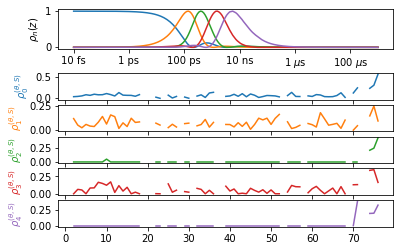

In [102]:
proj.close_fig('all')
mf_nmr.data.plot()

## Calculating rate constants

In [385]:
delta=proj[0].sens.info[0]['dXY']
DelSigma=proj[0].sens.info[0]['CSA']*3/2

def J(A,tc,v):  #v in MHz
    omega=2*np.pi*1e6
    return 2/5*A*tc/(1+(omega*tc)**2)

def R1(tc,A,v0H):  #v0H in MHz
    R1=0
    v0N=-v0H/10
    for tc0,A0 in zip(tc,A):
        R1+=(2*np.pi*delta/4)**2*(J(A0,tc0,v0H-v0N)+3*J(A0,tc0,v0N)+6*J(A0,tc0,v0H+v0N))
        R1+=1/3*(2*np.pi*v0N*DelSigma)
        

In [388]:
DelSigma*3/2*1/3

56.5

In [351]:
mf_nmr.__class__=MF
mf.__class__=MF

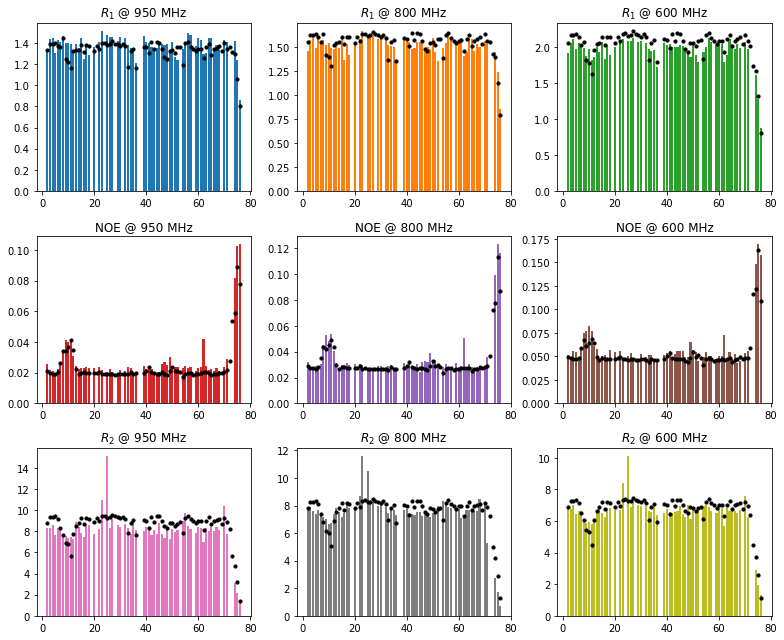

In [25]:
proj.close_fig('all')
_=mf.plot_rates()

<IPython.core.display.Javascript object>


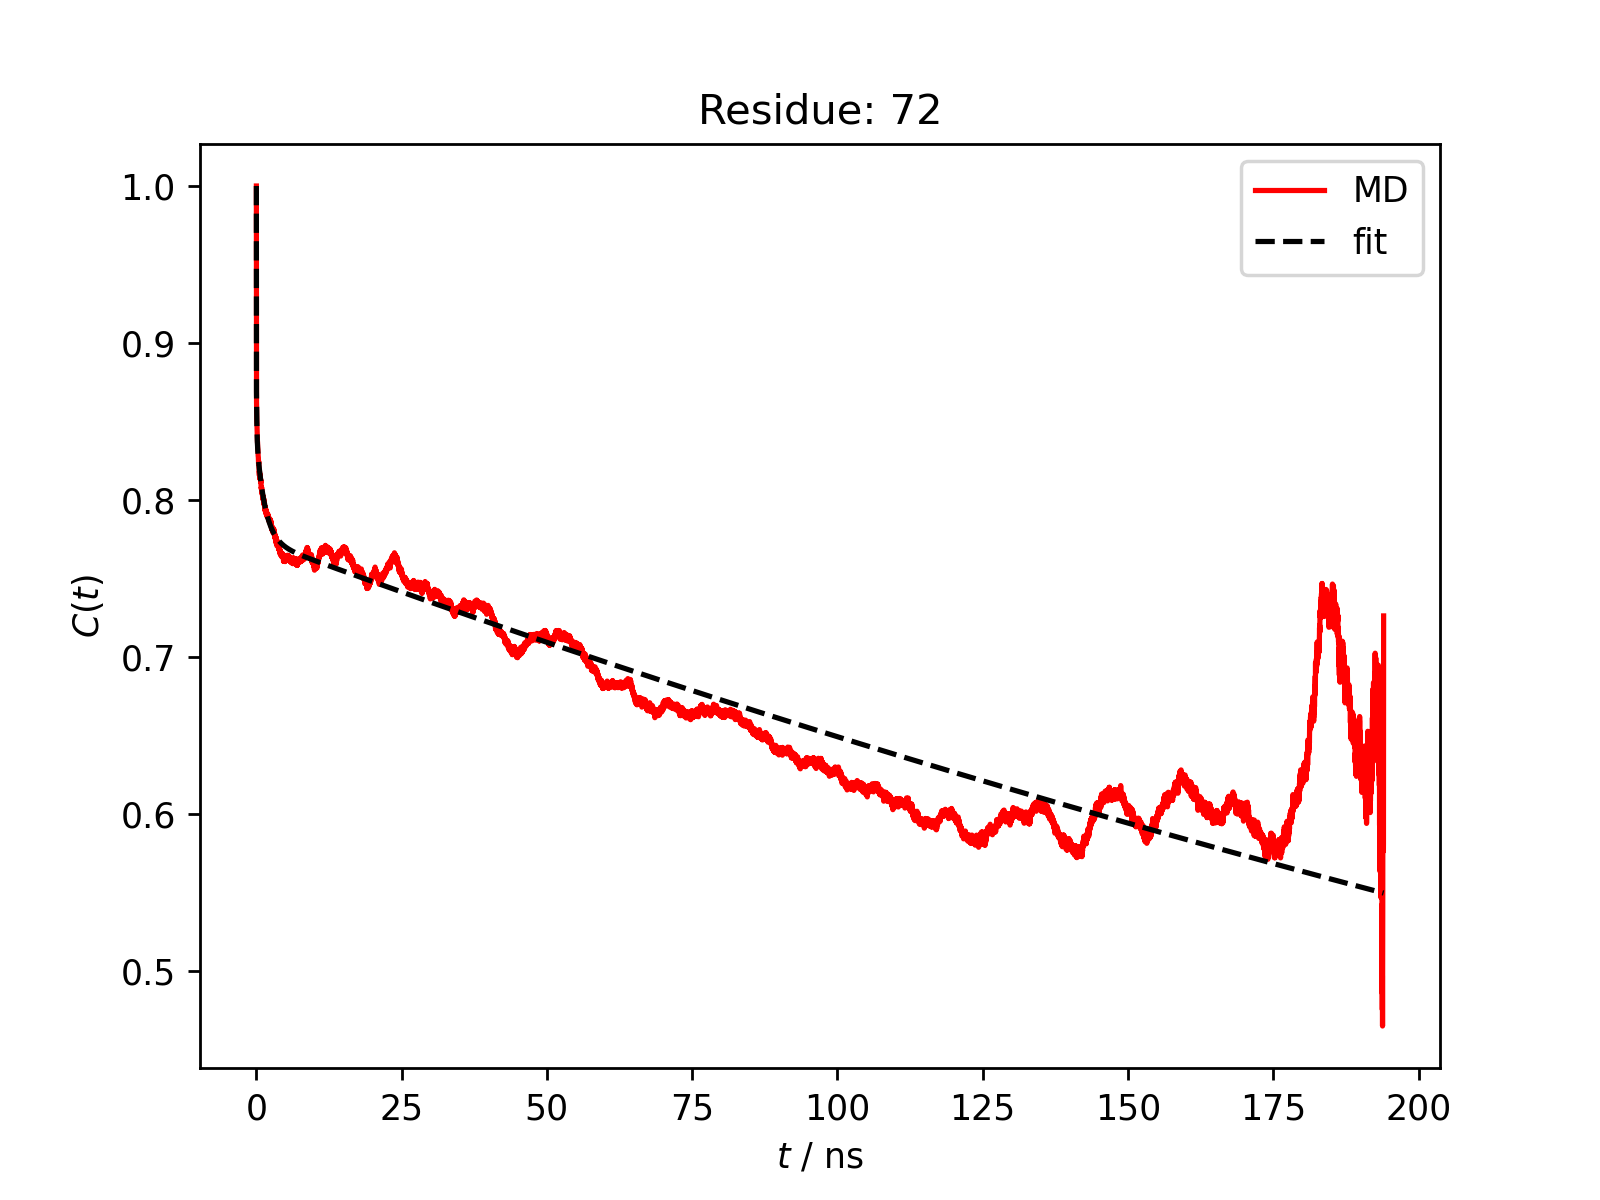

<AxesSubplot:title={'center':'Residue: 72'}, xlabel='$t$ / ns', ylabel='$C(t)$'>

In [364]:
mf.plot_ct(72)

Fitted 1 data objects
Fitted 1 data objects


/Users/albertsmith/Documents/GitHub.nosync/pyDR/Fitting/fit.py:400: RuntimeWarning: invalid value encountered in reciprocal
  pinv=((m**2).sum(1)**(-1))*m.T


Iterations |██████████████████████████████| 100%  of 64 steps
Completed


<IPython.core.display.Javascript object>


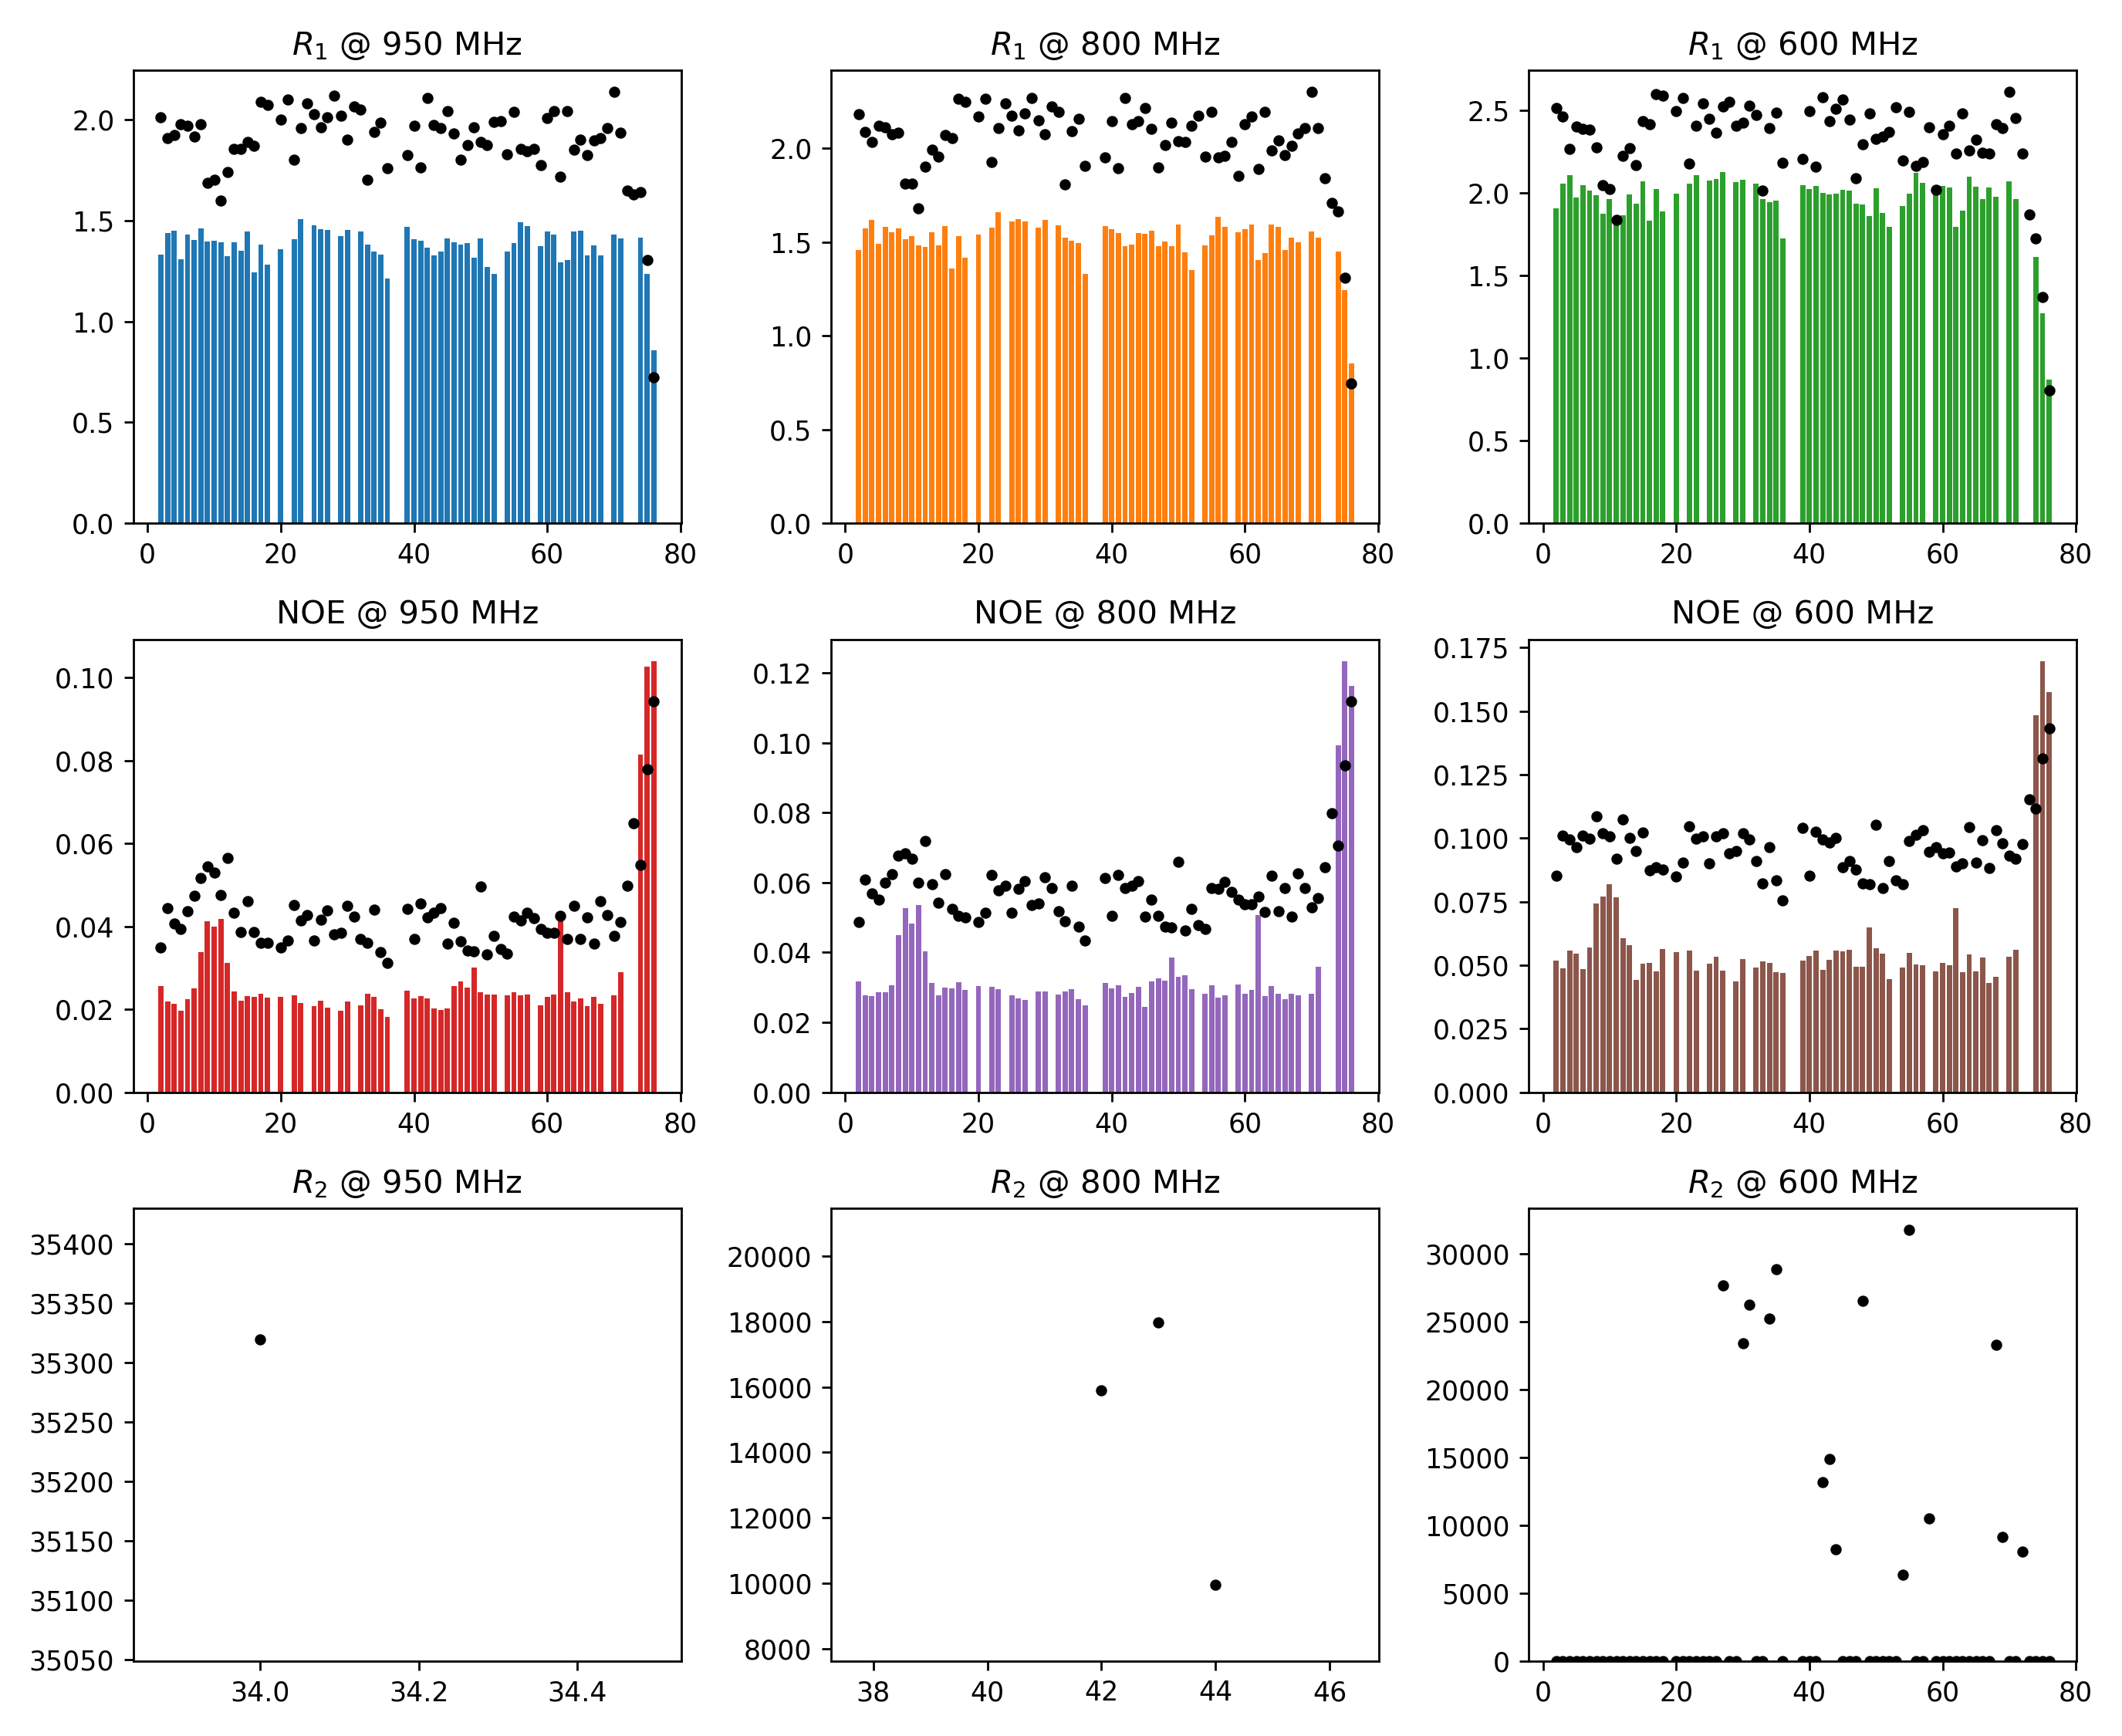

In [367]:
mf.aligned=False
_=mf.plot_rates(det=False)

<IPython.core.display.Javascript object>


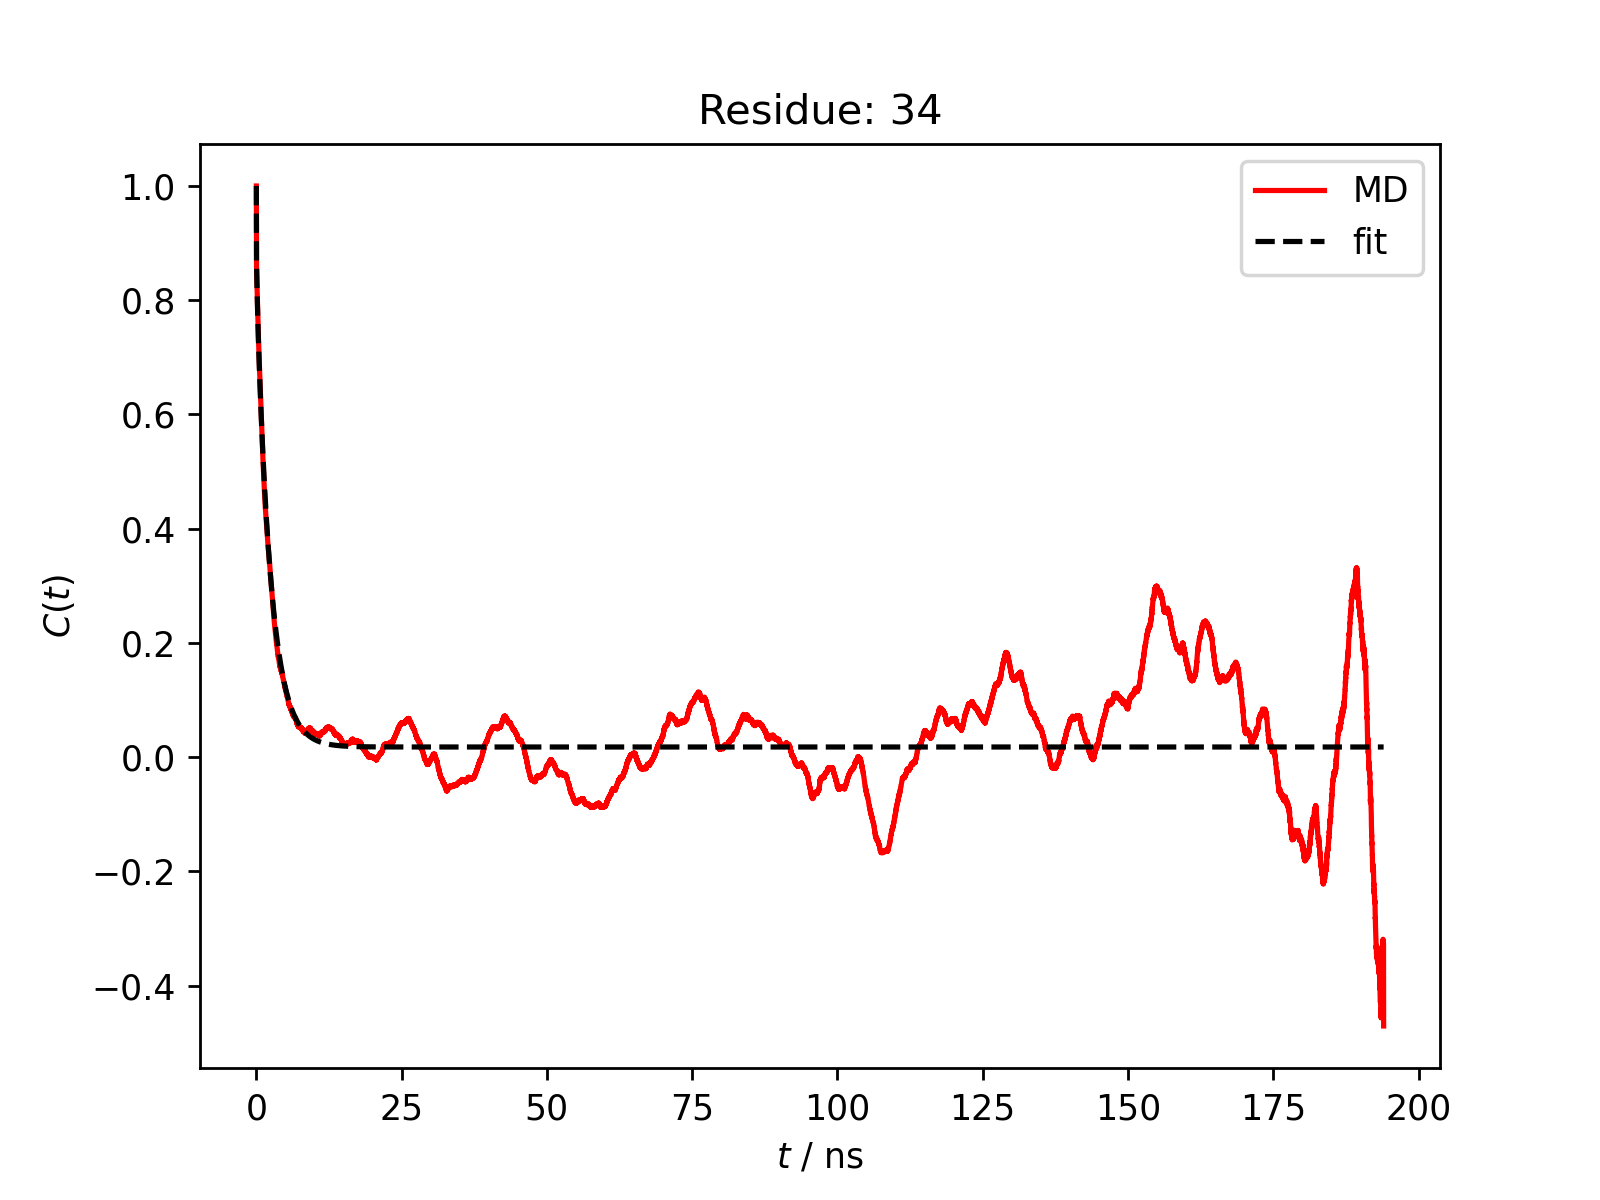

<AxesSubplot:title={'center':'Residue: 34'}, xlabel='$t$ / ns', ylabel='$C(t)$'>

In [377]:
mf.plot_ct(34)

<IPython.core.display.Javascript object>


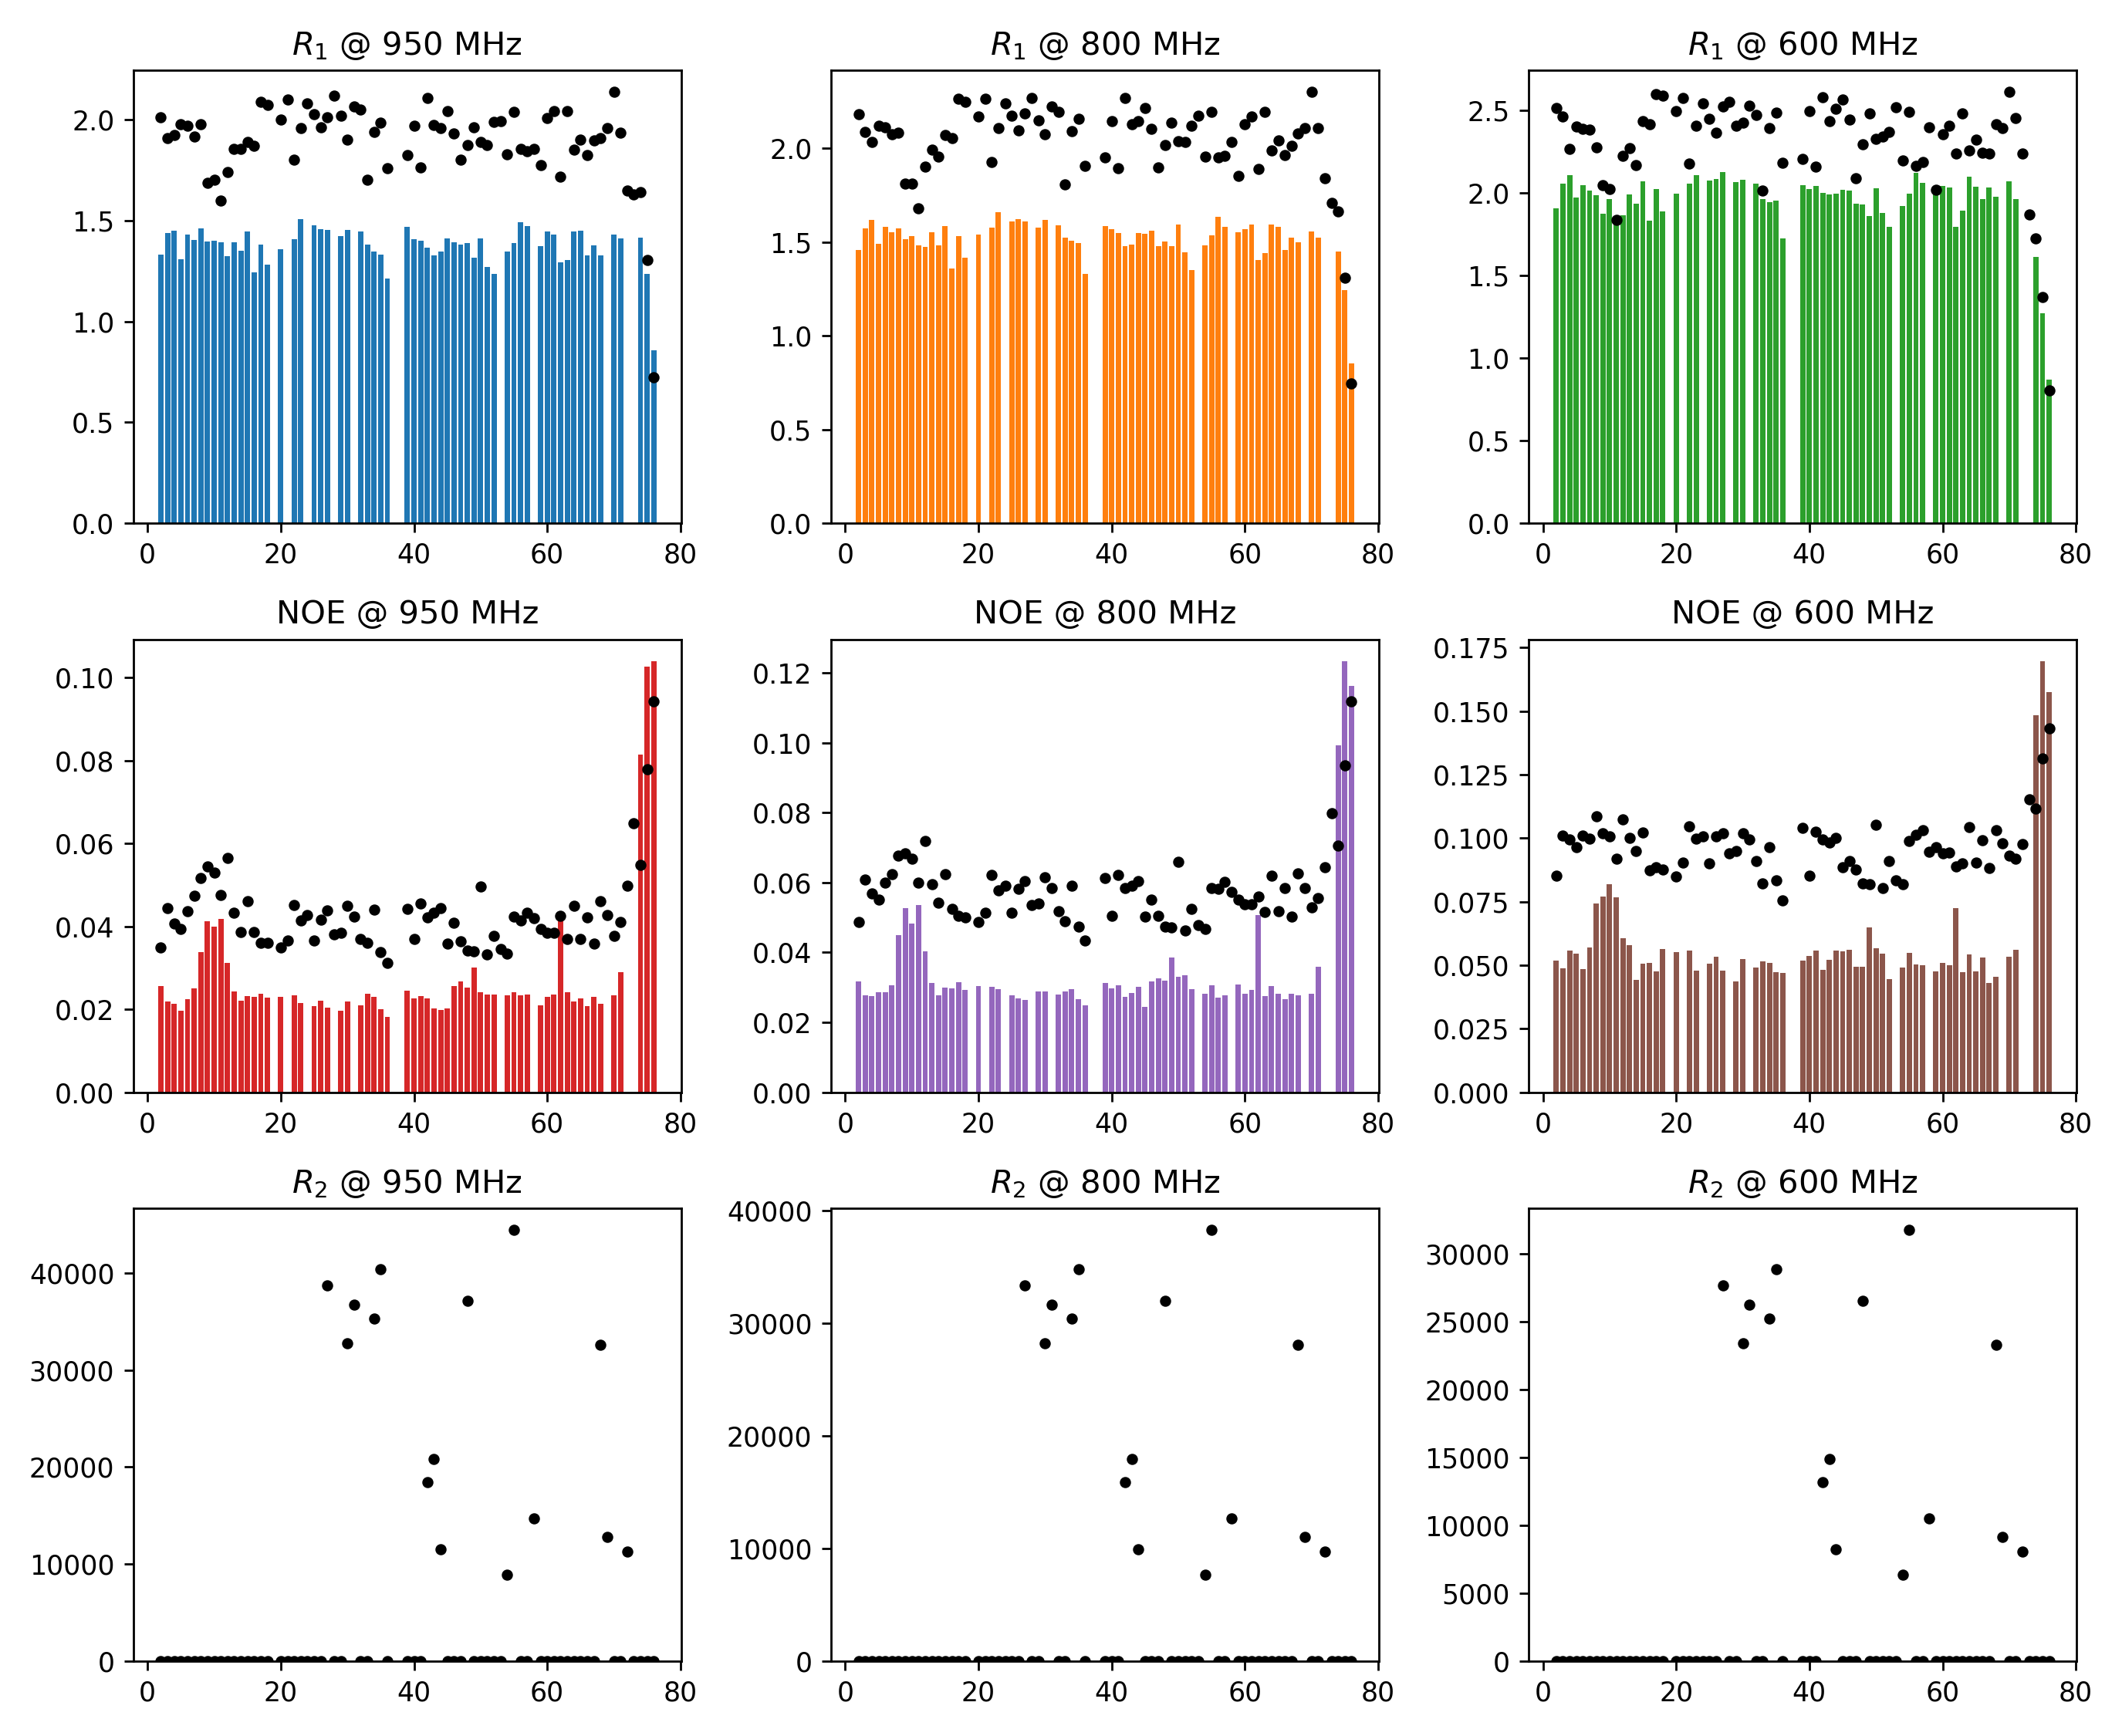

In [369]:
_=mf.plot_rates(det=True)

Fitted 1 data objects
Iterations |██████████████████████████████| 100%  of 4 steps
Completed


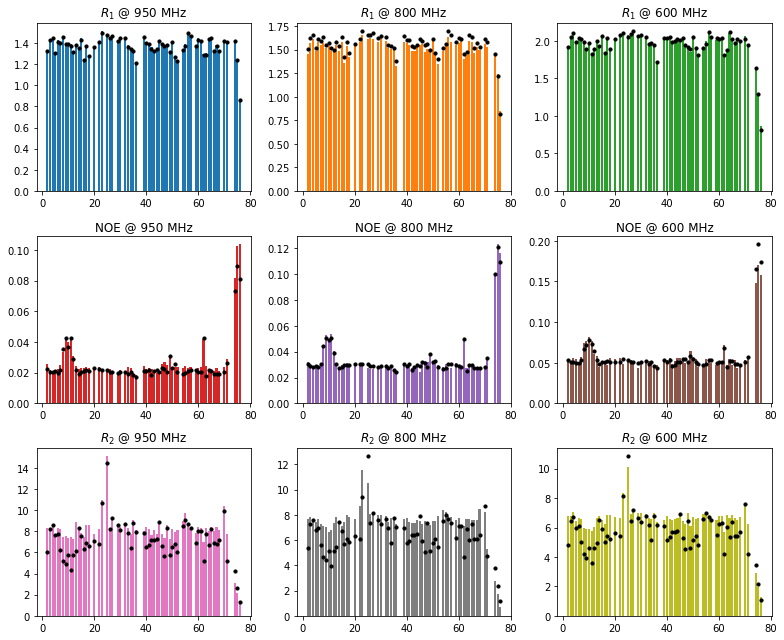

In [142]:
mf_nmr.aligned=False
mf_nmr.n=4
_=mf_nmr.plot_rates()

In [305]:
mf_nmr.__class__=MF
mf.__class__=MF

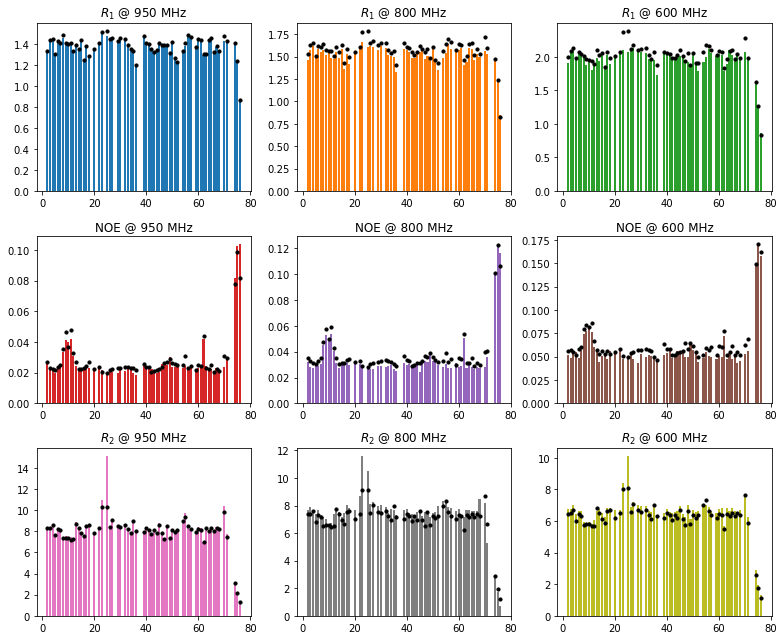

In [267]:
ax=mf_nmr.plot_rates()

In [255]:
mf=MF(Type='MD',aligned=False,n=7)

Fitted 1 data objects
Fitted 1 data objects


/Users/albertsmith/Documents/GitHub.nosync/pyDR/Fitting/fit.py:400: RuntimeWarning: invalid value encountered in reciprocal
  pinv=((m**2).sum(1)**(-1))*m.T


Iterations |██████████████████████████████| 100%  of 64 steps
Completed


<AxesSubplot:title={'center':'Residue: 55'}, xlabel='$t$ / ns', ylabel='$C(t)$'>

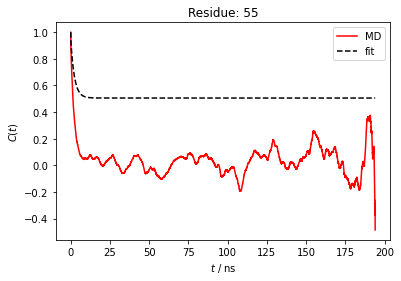

In [271]:
mf.plot_ct(resi=55)

Fitted 1 data objects
Iterations |██████████████████████████████| 100%  of 16 steps
Completed
Fitted 1 data objects
Iterations |██████████████████████████████| 100%  of 16 steps
Completed


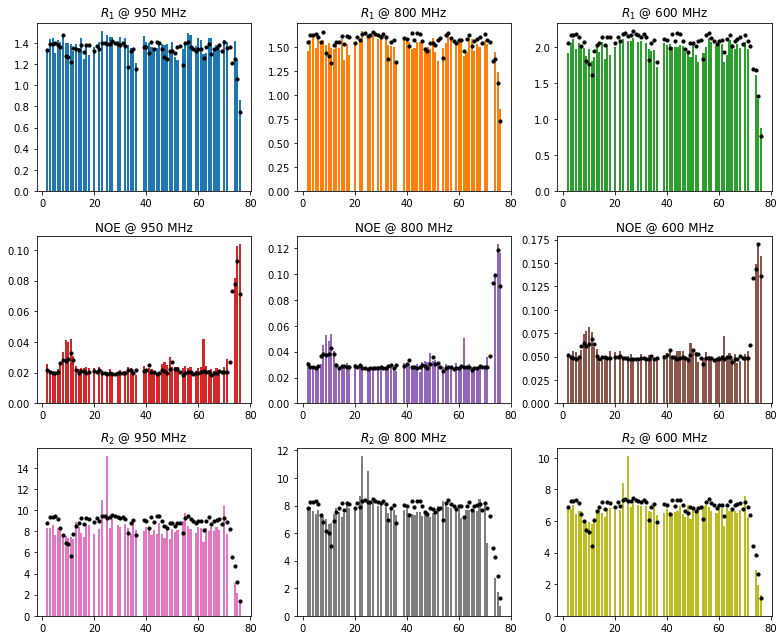

In [145]:
mf.aligned=True
mf.n=6
_=mf.plot_rates()

In [254]:
mf.n

7

In [187]:
proj['no_opt'][1].sens.sens

AssertionError: index too large for project of length 0

In [140]:
mf=MF(n=7)

/Users/albertsmith/Documents/GitHub.nosync/pyDR/Fitting/fit.py:400: RuntimeWarning: invalid value encountered in reciprocal
  pinv=((m**2).sum(1)**(-1))*m.T


Iterations |██████████████████████████████| 100%  of 64 steps
Completed
Data already in project (index=6)


<AxesSubplot:title={'center':'Residue: 55'}, xlabel='$t$ / ns', ylabel='$C(t)$'>

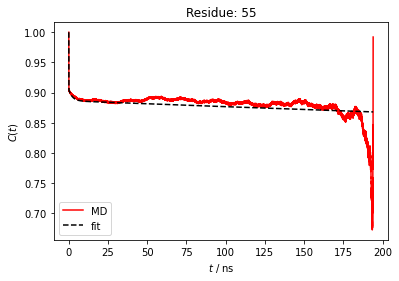

In [144]:
mf.plot_ct(55,semilog=False)

<IPython.core.display.Javascript object>


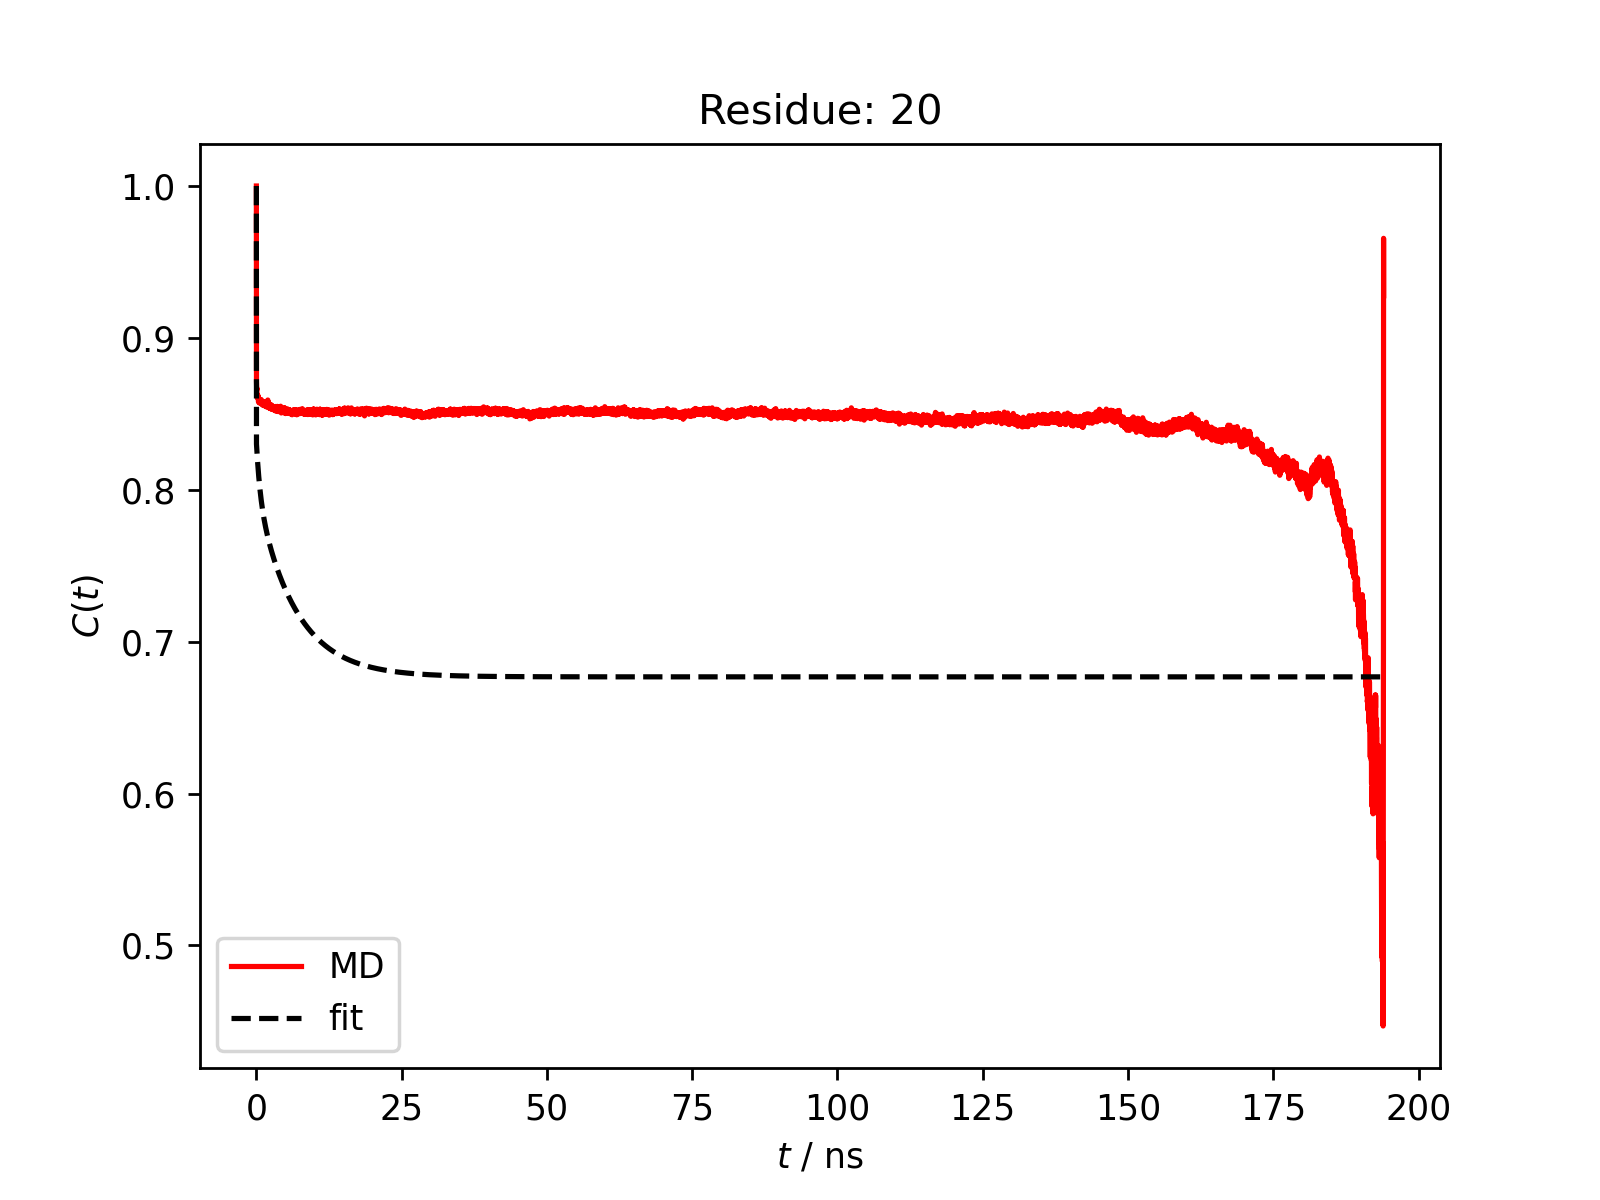

<AxesSubplot:title={'center':'Residue: 20'}, xlabel='$t$ / ns', ylabel='$C(t)$'>

In [378]:
mf_nmr.plot_ct(20,show_fit=True)

In [146]:
solnmr=proj['raw']['NMR'].sens
nmr=pyDR.Sens.NMR(info=solnmr.info)

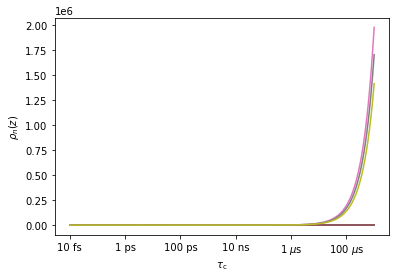

In [147]:
nmr.plot_rhoz()

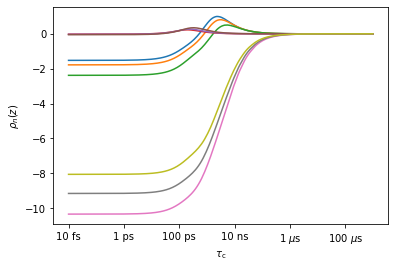

In [144]:
solnmr.plot_rhoz()

array([[<AxesSubplot:ylabel='A'>,
        <AxesSubplot:ylabel='$\\log_{10}(\\tau_c$ / s$)$'>],
       [<AxesSubplot:xlabel='Residue', ylabel='A'>,
        <AxesSubplot:xlabel='Residue', ylabel='$\\log_{10}(\\tau_c$ / s$)$'>]],
      dtype=object)

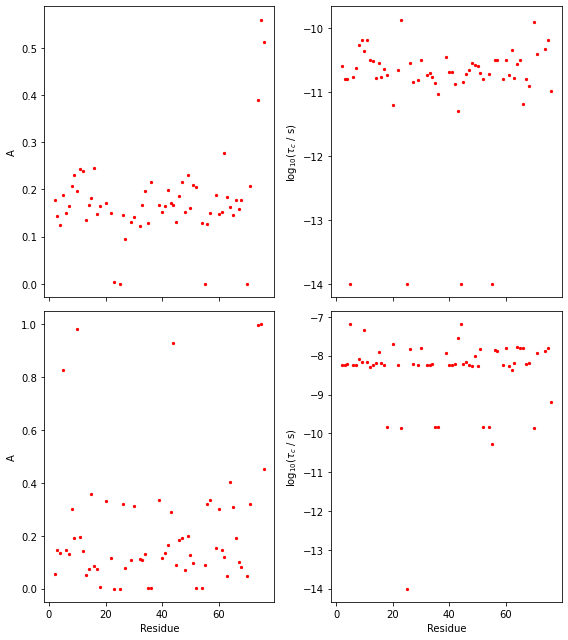

In [120]:
mf_nmr.plot_pars()

In [104]:
proj

pyDIFRATE project with 7 data sets

Titles:
r:NMR:ubi_soln
r:NMR:ubi
r:MD:ubi_aligned
r:MD:ubi
n7:NMR:ubi_soln
p5:NMR:ubi_soln
p5:MODELFREEFIT:ubi_soln


In [122]:
proj['MD']['no_opt'].detect.r_target(proj['NMR']['proc'][0].sens.rhoz,n=7)
proj['MD']['no_opt'].fit()
proj['MD']['proc'][-1].opt2dist(rhoz=proj['NMR']['proc'][0].sens.rhoz)

Fitted 1 data objects
o7:MD:ubi_aligned with 72 data points


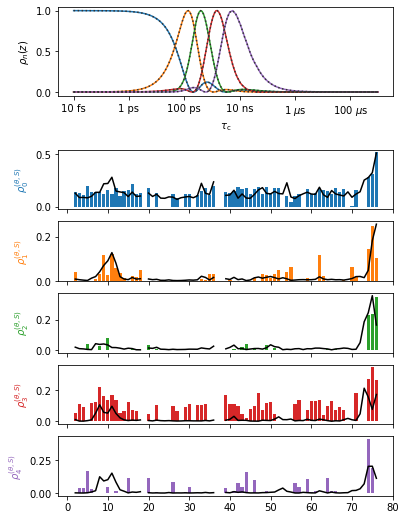

In [123]:
proj.close_fig('all')
proj['NMR']['proc'].plot(style='bar')
proj['MD']['opt_fit'][-1].plot()
proj.plot_obj.fig.set_size_inches([6,9])

array([<AxesSubplot:title={'center':'$R_1$ @ 950 MHz'}>,
       <AxesSubplot:title={'center':'$R_1$ @ 800 MHz'}>,
       <AxesSubplot:title={'center':'$R_1$ @ 600 MHz'}>,
       <AxesSubplot:title={'center':'NOE @ 950 MHz'}>,
       <AxesSubplot:title={'center':'NOE @ 800 MHz'}>,
       <AxesSubplot:title={'center':'NOE @ 600 MHz'}>,
       <AxesSubplot:title={'center':'$R_2$ @ 950 MHz'}>,
       <AxesSubplot:title={'center':'$R_2$ @ 800 MHz'}>,
       <AxesSubplot:title={'center':'$R_2$ @ 600 MHz'}>], dtype=object)

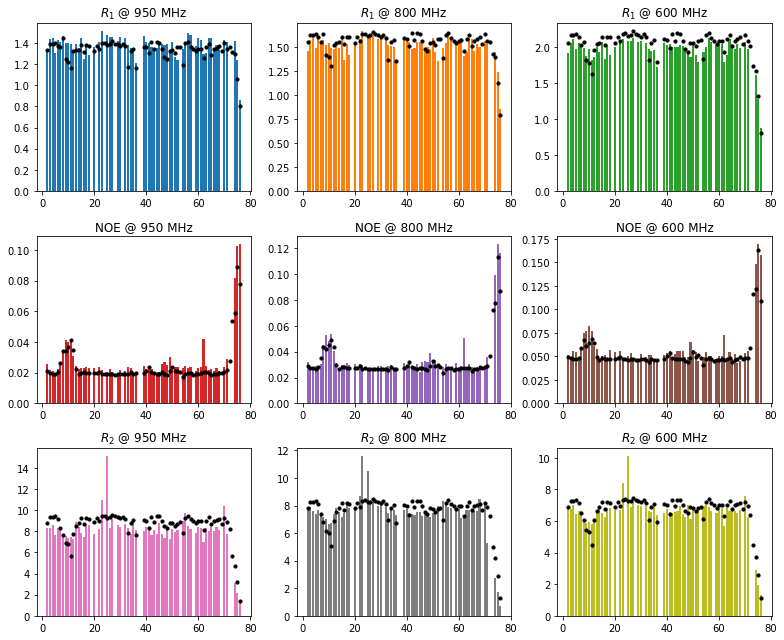

In [124]:
mf.plot_rates()

array([[<AxesSubplot:ylabel='A'>,
        <AxesSubplot:ylabel='$\\log_{10}(\\tau_c$ / s$)$'>],
       [<AxesSubplot:ylabel='A'>,
        <AxesSubplot:ylabel='$\\log_{10}(\\tau_c$ / s$)$'>],
       [<AxesSubplot:ylabel='A'>,
        <AxesSubplot:ylabel='$\\log_{10}(\\tau_c$ / s$)$'>],
       [<AxesSubplot:xlabel='Residue', ylabel='A'>,
        <AxesSubplot:xlabel='Residue', ylabel='$\\log_{10}(\\tau_c$ / s$)$'>]],
      dtype=object)

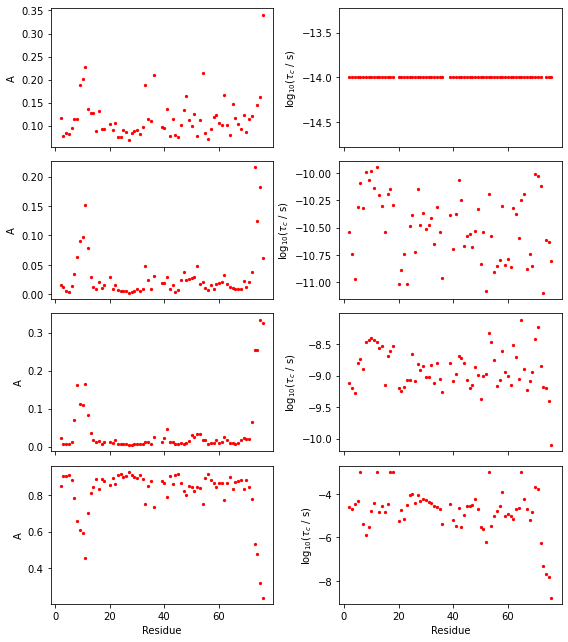

In [137]:
mf.plot_pars()

Iterations |██████████████████████████████| 100%  of 16 steps
Completed
Data already in project (index=9)


array([[<AxesSubplot:ylabel='A'>,
        <AxesSubplot:ylabel='$\\log_{10}(\\tau_c$ / s$)$'>],
       [<AxesSubplot:ylabel='A'>,
        <AxesSubplot:ylabel='$\\log_{10}(\\tau_c$ / s$)$'>],
       [<AxesSubplot:xlabel='Residue', ylabel='A'>,
        <AxesSubplot:xlabel='Residue', ylabel='$\\log_{10}(\\tau_c$ / s$)$'>]],
      dtype=object)

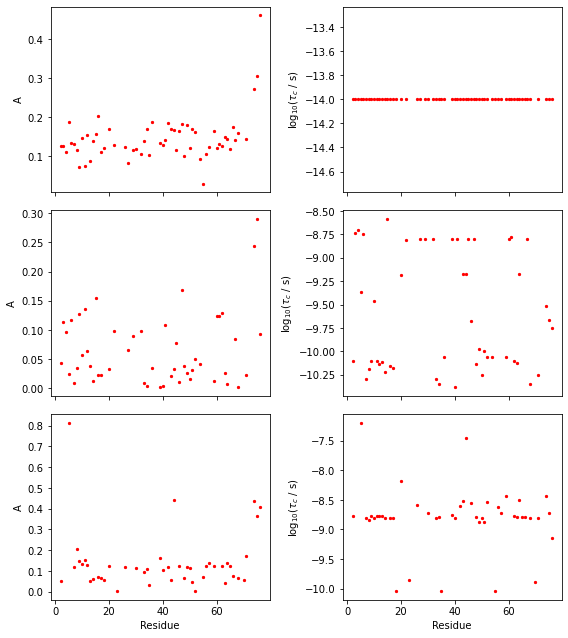

In [139]:
mf_nmr.n=5
mf_nmr.plot_pars()

In [133]:
(mf_nmr.A<1e-3).sum()

33